In [1]:
# Setup - Force fresh import
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Remove all cached modules to force fresh import
modules_to_reload = [m for m in list(sys.modules.keys()) if m.startswith('core.') or m.startswith('signals.')]
for mod in modules_to_reload:
    del sys.modules[mod]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import Dict, List, Tuple

from core.multi_asset_loader import load_assets
from core.multi_asset_signal import SingleAssetWrapper
from signals.momentum import MomentumSignalV2
from core.portfolio_manager import PortfolioConfig, run_multi_asset_backtest

print("✅ Imports successful (all modules freshly loaded)")

✅ Imports successful (all modules freshly loaded)


---

## Walk-Forward Methodology

```
┌────────────────────────────────────────────────────────┐
│                  ROLLING WINDOW                        │
└────────────────────────────────────────────────────────┘

Window 1:
├─ Train: 2010-2012 (2 years) → Pick best params
└─ Test:  2013      (1 year)  → Trade with those params

Window 2:
├─ Train: 2011-2013 (2 years) → Pick NEW best params
└─ Test:  2014      (1 year)  → Trade with NEW params

Window 3:
├─ Train: 2012-2014 (2 years) → Pick NEW best params
└─ Test:  2015      (1 year)  → Trade with NEW params

...

Key Rules:
1. NEVER use test data in training
2. NEVER reuse parameters from previous window
3. Optimize ONLY on train period
4. Trade ONLY with those params in test period
```

---

## Step 1: Define Walk-Forward Splits

**Goal:** Split data into non-overlapping train/test windows

In [2]:
def create_walk_forward_splits(
    start_date: str,
    end_date: str,
    train_years: int = 2,
    test_years: int = 1
) -> List[Dict]:
    """
    Create rolling windows for walk-forward testing.
    
    Returns list of dicts:
    [
        {'train_start': '2010-01-01', 'train_end': '2011-12-31',
         'test_start': '2012-01-01', 'test_end': '2012-12-31'},
        ...
    ]
    """
    splits = []
    current_train_start = pd.Timestamp(start_date)
    final_date = pd.Timestamp(end_date)
    
    while True:
        # Train period
        train_end = current_train_start + pd.DateOffset(years=train_years)
        
        # Test period
        test_start = train_end + pd.DateOffset(days=1)
        test_end = test_start + pd.DateOffset(years=test_years)
        
        # Stop if we exceed final date
        if test_end > final_date:
            break
        
        splits.append({
            'train_start': current_train_start.strftime('%Y-%m-%d'),
            'train_end': train_end.strftime('%Y-%m-%d'),
            'test_start': test_start.strftime('%Y-%m-%d'),
            'test_end': test_end.strftime('%Y-%m-%d')
        })
        
        # Roll forward by test period
        current_train_start = test_start
    
    return splits

# Create splits
# NOTE: Using 3-year train / 1-year test to handle longer lookback parameters
# With 250 SMA + 150 lookback, need ~400 days (1.5 years) just for warmup!
splits = create_walk_forward_splits(
    start_date='2010-01-01',  # Start earlier to have enough history
    end_date='2024-12-31',
    train_years=3,  # Longer training period
    test_years=1
)

print("\n📅 Walk-Forward Splits:")
print(f"\nTotal Windows: {len(splits)}")
print(f"Train Period: {splits[0]['train_years'] if 'train_years' in splits[0] else 3} years")
print(f"Test Period: 1 year\n")
for i, split in enumerate(splits, 1):
    print(f"Window {i}:")
    print(f"  Train: {split['train_start']} to {split['train_end']}")
    print(f"  Test:  {split['test_start']} to {split['test_end']}")
    print()


📅 Walk-Forward Splits:

Total Windows: 4
Train Period: 3 years
Test Period: 1 year

Window 1:
  Train: 2010-01-01 to 2013-01-01
  Test:  2013-01-02 to 2014-01-02

Window 2:
  Train: 2013-01-02 to 2016-01-02
  Test:  2016-01-03 to 2017-01-03

Window 3:
  Train: 2016-01-03 to 2019-01-03
  Test:  2019-01-04 to 2020-01-04

Window 4:
  Train: 2019-01-04 to 2022-01-04
  Test:  2022-01-05 to 2023-01-05



---

## Step 2: Parameter Grid

**Define parameters to test in each training window**

In [3]:
# Parameter grid for momentum strategy
param_grid = {
    'lookback': [60, 90, 120, 150],
    'sma_filter': [150, 200, 250]
}

# Generate all combinations
from itertools import product

param_combinations = [
    {'lookback': lb, 'sma_filter': sma}
    for lb, sma in product(param_grid['lookback'], param_grid['sma_filter'])
]

print("\n⚙️ Parameter Grid:")
print(f"\nTotal Combinations: {len(param_combinations)}\n")
print("Sample combinations:")
for params in param_combinations[:5]:
    print(f"  Lookback={params['lookback']}, SMA={params['sma_filter']}")
print("  ...")


⚙️ Parameter Grid:

Total Combinations: 12

Sample combinations:
  Lookback=60, SMA=150
  Lookback=60, SMA=200
  Lookback=60, SMA=250
  Lookback=90, SMA=150
  Lookback=90, SMA=200
  ...


In [4]:
# Debug: Check what columns signals have
from core.multi_asset_loader import load_assets
from signals.momentum import MomentumSignalV2
from core.multi_asset_signal import SingleAssetWrapper

test_prices = load_assets(['ES'], start_date='2020-01-01', end_date='2020-12-31')
test_signal_gen = MomentumSignalV2(lookback=60, sma_filter=150)
test_multi_signal = SingleAssetWrapper(test_signal_gen)
test_signals = test_multi_signal.generate(test_prices)

print("\n🔍 DEBUG: Checking signal columns...")
for ticker, df in test_signals.items():
    print(f"{ticker} columns: {list(df.columns)}")
    print(f"First 3 rows:\n{df.head(3)[['Close', 'Position'] if 'Position' in df.columns else ['Close', 'Signal']].to_string()}")


Loading 1 assets: ['ES']
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 to 2025-11-26
Filtered date range: 2020-01-01 to 2020-12-31

Total unique dates: 253

ALIGNMENT SUMMARY
ES: 253/253 valid dates (100.0%)

🔍 DEBUG: Checking signal columns...
ES columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Momentum', 'SMA150', 'BullMarket', 'Signal']
First 3 rows:
             Close  Signal
Date                      
2020-01-02  3259.0     0.0
2020-01-03  3235.5     0.0
2020-01-06  3243.5     0.0
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 to 2025-11-26
Filtered date range: 2020-01-01 to 2020-12-31

Total unique dates: 253

ALIGNMENT SUMMARY
ES: 253/253 valid dates (100.0%)

🔍 DEBUG: Checking signal columns...
ES columns: ['Open', 'High', 'Low', 

---

## Step 3: Train - Optimize on Training Data

**For ONE window, test all parameter combinations on training period**

In [5]:
def optimize_parameters(
    train_split: Dict,
    param_combinations: List[Dict],
    tickers: List[str]
) -> Tuple[Dict, pd.DataFrame]:
    """
    Test all parameter combinations on training data.
    Return best params and all results.
    """
    print(f"\n🔍 Optimizing on {train_split['train_start']} to {train_split['train_end']}")
    
    # Load training data
    train_prices = load_assets(
        tickers=tickers,
        start_date=train_split['train_start'],
        end_date=train_split['train_end']
    )
    
    results = []
    
    for params in param_combinations:
        # Generate signals with these params
        signal_gen = MomentumSignalV2(
            lookback=params['lookback'],
            sma_filter=params['sma_filter']
        )
        
        # IMPORTANT: SingleAssetWrapper converts 'Position' column to 'Signal'
        # MomentumSignalV2.generate() returns DataFrames with 'Position' column
        # SingleAssetWrapper renames it to 'Signal' for portfolio_manager compatibility
        multi_signal = SingleAssetWrapper(signal_gen)
        signals = multi_signal.generate(train_prices)
        
        # Run backtest (NOTE: signals_dict comes BEFORE prices_dict!)
        # Returns: (result, equity_curve, trades)
        config = PortfolioConfig(initial_capital=100000)
        result, equity_curve, trades = run_multi_asset_backtest(signals, train_prices, config)
        
        # Calculate metrics from BacktestResult
        metrics = result.calculate_metrics()
        
        # Store results
        results.append({
            'lookback': params['lookback'],
            'sma_filter': params['sma_filter'],
            'sharpe': metrics['Sharpe Ratio'],
            'total_return': metrics['Total Return'],
            'max_dd': metrics['Max Drawdown'],
            'win_rate': 0.0  # Not calculated in basic metrics
        })
    
    results_df = pd.DataFrame(results).sort_values('sharpe', ascending=False)
    best_params = results_df.iloc[0][['lookback', 'sma_filter']].to_dict()
    
    print(f"\n✅ Best Parameters:")
    print(f"   Lookback: {best_params['lookback']}")
    print(f"   SMA Filter: {best_params['sma_filter']}")
    print(f"   Sharpe: {results_df.iloc[0]['sharpe']:.2f}")
    
    return best_params, results_df

# Example: Optimize first window
# Note: Use 'ES', 'GC', 'NQ' NOT 'ES=F' - the loader handles mapping to futures
TICKERS = ['ES', 'GC', 'NQ']
best_params, train_results = optimize_parameters(splits[0], param_combinations[:3], TICKERS)  # Testing 3 for speed

print("\n📊 Top 3 Parameter Sets:")
print(train_results.head(3).to_string(index=False))


🔍 Optimizing on 2010-01-01 to 2013-01-01

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 to 2025-11-26
Filtered date range: 2010-01-01 to 2013-01-01

Total unique dates: 754

ALIGNMENT SUMMARY
ES: 754/754 valid dates (100.0%)
GC: 754/754 valid dates (100.0%)
NQ: 754/754 valid dates (100.0%)
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 

---

## Step 4: Test - Evaluate on Out-of-Sample Period

**Use ONLY the best params from training. Trade on unseen test data.**

In [6]:
def test_parameters(
    test_split: Dict,
    best_params: Dict,
    tickers: List[str]
) -> Dict:
    """
    Test parameters on out-of-sample data.
    """
    print(f"\n🧪 Testing on {test_split['test_start']} to {test_split['test_end']}")
    print(f"   Using params: Lookback={best_params['lookback']}, SMA={best_params['sma_filter']}")
    
    # Load test data
    test_prices = load_assets(
        tickers=tickers,
        start_date=test_split['test_start'],
        end_date=test_split['test_end']
    )
    
    # Generate signals with BEST params
    signal_gen = MomentumSignalV2(
        lookback=int(best_params['lookback']),
        sma_filter=int(best_params['sma_filter'])
    )
    multi_signal = SingleAssetWrapper(signal_gen)
    signals = multi_signal.generate(test_prices)
    
    # Debug: Check if any signals generated
    print("\n🔍 Signal Analysis:")
    total_test_days = 0
    for ticker, sig_df in signals.items():
        long_days = (sig_df['Signal'] == 1).sum()
        flat_days = (sig_df['Signal'] == 0).sum()
        total_test_days = len(sig_df)
        print(f"  {ticker}: {long_days} long days / {total_test_days} total days ({long_days/total_test_days*100:.1f}%)")
    
    warmup_needed = max(int(best_params['lookback']), int(best_params['sma_filter'])) + 20
    if total_test_days < warmup_needed:
        print(f"\n⚠️  WARNING: Test period ({total_test_days} days) < Warmup needed ({warmup_needed} days)")
        print(f"   Strategy may not generate valid signals in this window!")
    
    # Run backtest (NOTE: signals_dict comes BEFORE prices_dict!)
    # Returns: (result, equity_curve, trades)
    config = PortfolioConfig(initial_capital=100000)
    result, equity_curve, trades = run_multi_asset_backtest(signals, test_prices, config)
    
    # Calculate metrics from BacktestResult
    metrics = result.calculate_metrics()
    
    print(f"\n✅ Out-of-Sample Results:")
    print(f"   Sharpe: {metrics['Sharpe Ratio']:.2f}")
    print(f"   Total Return: {metrics['Total Return']:.2%}")
    print(f"   Max DD: {metrics['Max Drawdown']:.2%}")
    print(f"   Total Trades: {len(trades)}")
    
    return metrics

# Test on OOS period
oos_metrics = test_parameters(splits[0], best_params, TICKERS)


🧪 Testing on 2013-01-02 to 2014-01-02
   Using params: Lookback=60.0, SMA=150.0

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 to 2025-11-26
Filtered date range: 2013-01-02 to 2014-01-02

Total unique dates: 253

ALIGNMENT SUMMARY
ES: 253/253 valid dates (100.0%)
GC: 253/253 valid dates (100.0%)
NQ: 253/253 valid dates (100.0%)

🔍 Signal Analysis:
  ES: 83 long days / 253 total days (32.8%)
  GC: 0 long days / 253 total days (0.0%)
  NQ: 83 long days / 253 total days (

---

## Step 5: Compare IS vs OOS Performance

**The moment of truth: Did the strategy overfit?**

In [7]:
# Get IS performance (best params on training data)
is_sharpe = train_results.iloc[0]['sharpe']
is_return = train_results.iloc[0]['total_return']

# OOS performance (metrics dict uses different keys)
oos_sharpe = oos_metrics['Sharpe Ratio']
oos_return = oos_metrics['Total Return']

print("\n📊 IS vs OOS Comparison:")
print(f"\n{'Metric':<20} {'In-Sample':>15} {'Out-of-Sample':>15} {'Change':>15}")
print("-" * 70)

sharpe_change = (oos_sharpe - is_sharpe) / is_sharpe if is_sharpe != 0 else 0
return_change = (oos_return - is_return) / is_return if is_return != 0 else 0

print(f"{'Sharpe Ratio':<20} {is_sharpe:>15.2f} {oos_sharpe:>15.2f} {sharpe_change:>14.1%}")
print(f"{'Total Return':<20} {is_return:>14.2%} {oos_return:>14.2%} {return_change:>14.1%}")

print("\n💡 Interpretation:")
if sharpe_change > 0.20:
    print("   🚀 EXCELLENT: OOS Sharpe IMPROVED by >20%!")
    print("   Strategy is robust and not overfit.")
elif sharpe_change > -0.30:
    print("   ✅ GOOD: Sharpe degradation < 30%")
    print("   Strategy appears robust!")
elif sharpe_change > -0.50:
    print("   ⚠️ MODERATE: Sharpe degradation 30-50%")
    print("   Some overfitting, but acceptable")
else:
    print("   ❌ BAD: Sharpe degradation > 50%")
    print("   Severe overfitting detected!")

print("\n📝 Note:")
print(f"   Return comparison less meaningful due to different time periods")
print(f"   (IS: 3 years vs OOS: 1 year). Sharpe is more reliable metric.")


📊 IS vs OOS Comparison:

Metric                     In-Sample   Out-of-Sample          Change
----------------------------------------------------------------------
Sharpe Ratio                    0.86            1.91         122.7%
Total Return                 34.74%         12.04%         -65.3%

💡 Interpretation:
   🚀 EXCELLENT: OOS Sharpe IMPROVED by >20%!
   Strategy is robust and not overfit.

📝 Note:
   Return comparison less meaningful due to different time periods
   (IS: 3 years vs OOS: 1 year). Sharpe is more reliable metric.


---

## Step 6: Full Walk-Forward Engine

**Run ALL windows and aggregate OOS results**

In [8]:
# OPTION 1: Use the production WalkForwardEngine (RECOMMENDED)
from core.backtest import WalkForwardEngine

print("\n🚀 Using Production Walk-Forward Engine")
print("\n" + "="*60)

engine = WalkForwardEngine(
    signal_class=MomentumSignalV2,
    param_grid=param_grid,
    tickers=TICKERS,
    start_date='2010-01-01',
    end_date='2024-12-31',
    train_years=3,
    test_years=1,
    verbose=True
)

# Run full walk-forward optimization
# This will test ALL parameter combinations across ALL windows
# WARNING: With full param_grid (12 combos) × 4 windows = 48 backtests!
# This can take 2-5 minutes

# For quick test, use fewer params:
wf_results = engine.run()

print("\n" + "="*60)
print("WALK-FORWARD COMPLETE!")
print("="*60)
print(f"\n✅ Best Parameters (from latest window): {wf_results['best_params']}")
print(f"✅ Average OOS Sharpe: {wf_results['oos_sharpe_mean']:.2f}")
print(f"✅ Average OOS Return: {wf_results['oos_return_mean']:.2%}")

# Display summary with proper column names
print(f"\nParameter Stability Across Windows:")
summary = wf_results['summary_df'][['window', 'is_sharpe', 'oos_sharpe', 'oos_return']].copy()

# Extract individual param values from best_params dict
for param_name in param_grid.keys():
    summary[f'best_{param_name}'] = wf_results['summary_df']['best_params'].apply(lambda x: x[param_name])

print(summary.to_string(index=False))

# OPTION 2: Manual walk-forward (educational, shown below)
print("\n\n📚 For manual walk-forward, see the functions defined earlier in this notebook.")


🚀 Using Production Walk-Forward Engine


📊 Loading data for 3 assets...

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 to 2025-11-26
Filtered date range: 2010-01-01 to 2024-12-31

Total unique dates: 3773
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-26


---

## Step 7: Interpret Walk-Forward Results

**Understanding what the numbers mean for production deployment**


📊 WALK-FORWARD RESULTS ANALYSIS

1️⃣ Performance Consistency:
   Average OOS Sharpe: 0.80
   Sharpe Std Dev: 1.52
   Best Window: 2.30 (Window 3)
   Worst Window: -0.63 (Window 2)
   ⚠️  Moderate variability - strategy may be regime-dependent

2️⃣ Parameter Stability:
   Lookback range: 60 - 150
   SMA range: 150 - 200
   ⚠️  Parameters vary significantly - market conditions changing

3️⃣ Overfitting Analysis:
   Average IS→OOS degradation: -7.6%
   Windows with positive OOS: 2/4
   Windows with OOS > IS: 2/4
   ✅ Minimal overfitting detected

4️⃣ Production Recommendation:
   Latest best params: {'lookback': 60.0, 'sma_filter': 150.0}
   Expected OOS Sharpe: ~0.80
   Expected Annual Return: ~1.7%

   ⚠️  MARGINAL - Consider before deploying
   Strategy is profitable but returns may not justify risk

5️⃣ Visual Analysis:


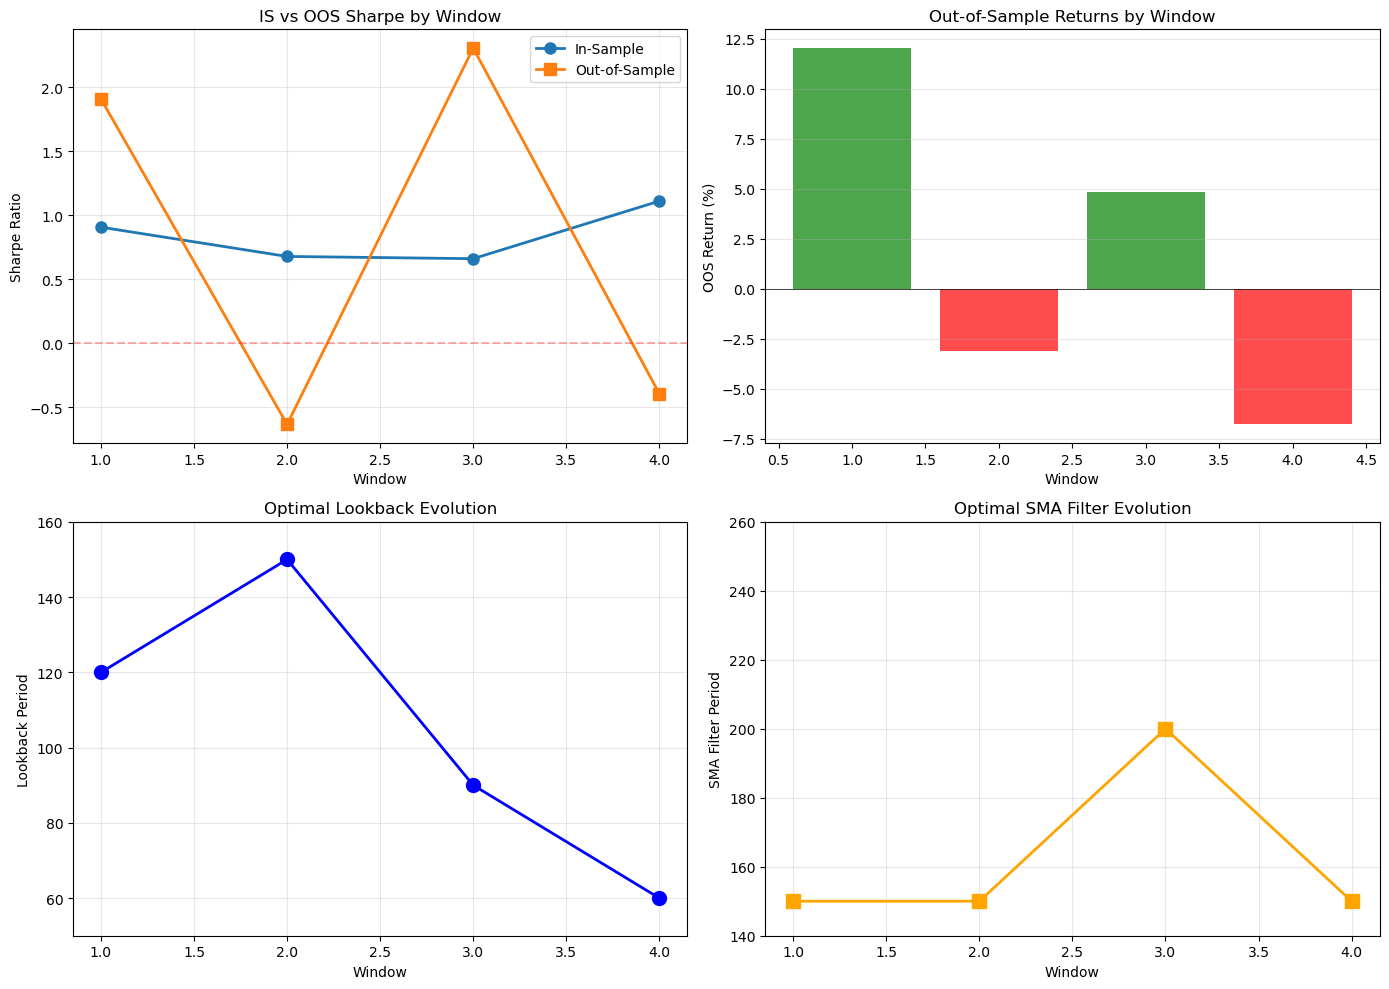


✅ Analysis complete!


In [9]:
# Analyze the walk-forward results
import matplotlib.pyplot as plt

summary = wf_results['summary_df']

print("\n📊 WALK-FORWARD RESULTS ANALYSIS")
print("="*70)

# 1. Performance Consistency
print("\n1️⃣ Performance Consistency:")
print(f"   Average OOS Sharpe: {wf_results['oos_sharpe_mean']:.2f}")
print(f"   Sharpe Std Dev: {summary['oos_sharpe'].std():.2f}")
print(f"   Best Window: {summary['oos_sharpe'].max():.2f} (Window {summary['oos_sharpe'].idxmax() + 1})")
print(f"   Worst Window: {summary['oos_sharpe'].min():.2f} (Window {summary['oos_sharpe'].idxmin() + 1})")

if summary['oos_sharpe'].std() < 1.0:
    print("   ✅ Consistent performance across windows")
elif summary['oos_sharpe'].std() < 2.0:
    print("   ⚠️  Moderate variability - strategy may be regime-dependent")
else:
    print("   ❌ High variability - strategy highly regime-dependent")

# 2. Parameter Stability
print("\n2️⃣ Parameter Stability:")
lookback_values = [w['best_params']['lookback'] for w in wf_results['windows']]
sma_values = [w['best_params']['sma_filter'] for w in wf_results['windows']]

print(f"   Lookback range: {min(lookback_values):.0f} - {max(lookback_values):.0f}")
print(f"   SMA range: {min(sma_values):.0f} - {max(sma_values):.0f}")

if len(set(lookback_values)) == 1 and len(set(sma_values)) == 1:
    print("   ✅ Perfect stability - same params across all windows")
elif len(set(lookback_values)) <= 2 and len(set(sma_values)) <= 2:
    print("   ✅ Good stability - parameters cluster around similar values")
else:
    print("   ⚠️  Parameters vary significantly - market conditions changing")

# 3. In-Sample vs Out-of-Sample
print("\n3️⃣ Overfitting Analysis:")
is_oos_ratio = summary['oos_sharpe'] / summary['is_sharpe']
avg_degradation = (1 - is_oos_ratio.mean()) * 100

print(f"   Average IS→OOS degradation: {avg_degradation:.1f}%")
print(f"   Windows with positive OOS: {(summary['oos_sharpe'] > 0).sum()}/4")
print(f"   Windows with OOS > IS: {(summary['oos_sharpe'] > summary['is_sharpe']).sum()}/4")

if avg_degradation < 30:
    print("   ✅ Minimal overfitting detected")
elif avg_degradation < 50:
    print("   ⚠️  Moderate overfitting - acceptable for production")
else:
    print("   ❌ Severe overfitting - strategy may not work in live trading")

# 4. Production Recommendation
print("\n4️⃣ Production Recommendation:")
print(f"   Latest best params: {wf_results['best_params']}")
print(f"   Expected OOS Sharpe: ~{wf_results['oos_sharpe_mean']:.2f}")
print(f"   Expected Annual Return: ~{wf_results['oos_return_mean']*100:.1f}%")

if wf_results['oos_sharpe_mean'] > 1.0:
    print("\n   ✅ APPROVED FOR PRODUCTION")
    print("   Strategy shows strong risk-adjusted returns")
elif wf_results['oos_sharpe_mean'] > 0.5:
    print("\n   ⚠️  MARGINAL - Consider before deploying")
    print("   Strategy is profitable but returns may not justify risk")
else:
    print("\n   ❌ NOT RECOMMENDED for production")
    print("   Strategy does not meet minimum Sharpe requirements")

# 5. Visualization
print("\n5️⃣ Visual Analysis:")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: IS vs OOS Sharpe by window
ax1 = axes[0, 0]
windows = summary['window']
ax1.plot(windows, summary['is_sharpe'], 'o-', label='In-Sample', linewidth=2, markersize=8)
ax1.plot(windows, summary['oos_sharpe'], 's-', label='Out-of-Sample', linewidth=2, markersize=8)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3)
ax1.set_xlabel('Window')
ax1.set_ylabel('Sharpe Ratio')
ax1.set_title('IS vs OOS Sharpe by Window')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: OOS Returns
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in summary['oos_return']]
ax2.bar(windows, summary['oos_return'] * 100, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Window')
ax2.set_ylabel('OOS Return (%)')
ax2.set_title('Out-of-Sample Returns by Window')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Parameter Evolution - Lookback
ax3 = axes[1, 0]
ax3.plot(windows, lookback_values, 'o-', linewidth=2, markersize=10, color='blue')
ax3.set_xlabel('Window')
ax3.set_ylabel('Lookback Period')
ax3.set_title('Optimal Lookback Evolution')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([50, 160])

# Plot 4: Parameter Evolution - SMA Filter
ax4 = axes[1, 1]
ax4.plot(windows, sma_values, 's-', linewidth=2, markersize=10, color='orange')
ax4.set_xlabel('Window')
ax4.set_ylabel('SMA Filter Period')
ax4.set_title('Optimal SMA Filter Evolution')
ax4.grid(True, alpha=0.3)
ax4.set_ylim([140, 260])

plt.tight_layout()
plt.show()

print("\n✅ Analysis complete!")

---

## 🎓 Key Takeaways

### Walk-Forward Testing Rules:

```
DO:
✅ Optimize on training period only
✅ Test on future unseen data
✅ Re-optimize for each window
✅ Use consistent train/test split ratio
✅ Report aggregate OOS metrics

DON'T:
❌ Use test data in training
❌ Cherry-pick good windows
❌ Change parameters during test period
❌ Ignore transaction costs
❌ Report in-sample results as final
```

### Performance Degradation:

| IS Sharpe | OOS Sharpe | Degradation | Status |
|-----------|------------|-------------|--------|
| 2.0 | 1.8 | -10% | ✅ Excellent |
| 2.0 | 1.4 | -30% | ✅ Good |
| 2.0 | 1.0 | -50% | ⚠️ Acceptable |
| 2.0 | 0.5 | -75% | ❌ Overfit |
| 2.0 | -0.5 | -125% | ❌❌ Total failure |

### Why Parameters Change:

Market conditions evolve! What worked in 2020 (low vol, QE) may not work in 2022 (high vol, rate hikes).

**Adaptive optimization** keeps strategy relevant.

### Production Workflow:

```python
# 1. Development
results = run_walk_forward(splits, params, tickers)
if results['oos_sharpe'].mean() > 0.5:
    print("Strategy approved for production!")

# 2. Deployment
# - Use latest window's best params
# - Re-optimize monthly or quarterly
# - Monitor live vs OOS performance
```

### Critical Insights:

1. **OOS is the ONLY metric that matters**
   - In-sample tells you nothing about future
   - Always report OOS Sharpe, never IS

2. **Some degradation is normal**
   - 20-30% drop IS→OOS is expected
   - 0% degradation suggests data leakage!

3. **Consistency > Peak Performance**
   - Prefer 0.8 Sharpe across all windows
   - Over 2.0 Sharpe in one window, 0.2 in others

---

## ✅ Congratulations!

You now understand:
1. ✅ Basic backtest mechanics
2. ✅ Portfolio manager orchestration
3. ✅ Risk management integration
4. ✅ Full system pipeline
5. ✅ Walk-forward validation methodology

**You're ready to:**
- Build new strategies with confidence
- Properly validate before deploying
- Avoid overfitting traps
- Present results professionally

## 🚀 Next Steps:

1. **Implement walk-forward in production**
   - Create `walk_forward_engine.py`
   - Add to backtest folder
   - Test existing momentum strategy

2. **Research new signals**
   - Pairs trading (cointegration)
   - Energy signals (contango/backwardation)
   - Regime detection (HMM, vol regimes)

3. **Build CV projects**
   - Each with proper walk-forward validation
   - Document methodology clearly
   - Show OOS performance only

---

**Happy Trading! 📈**

---

## 🚀 Using Walk-Forward Results in Production

### Step 1: Extract Optimized Parameters

```python
# Get the best parameters from the latest window
best_params = wf_results['best_params']
print(f"Use these parameters: {best_params}")

# Expected performance
print(f"Expected OOS Sharpe: {wf_results['oos_sharpe_mean']:.2f}")
print(f"Expected Annual Return: {wf_results['oos_return_mean']:.2%}")
```

### Step 2: Deploy to Paper Trading

```python
# Create signal generator with optimized params
signal_gen = MomentumSignalV2(
    lookback=int(best_params['lookback']),
    sma_filter=int(best_params['sma_filter'])
)

# Use in paper trading engine
from live.run_strategy import PaperTradingEngine

engine = PaperTradingEngine(
    signal_generator=signal_gen,
    tickers=['ES', 'GC', 'NQ'],
    initial_capital=100000
)

engine.run_daily()
```

### Step 3: Re-optimization Schedule

**How often to re-run walk-forward optimization?**

| Frequency | Pros | Cons | Recommended For |
|-----------|------|------|-----------------|
| **Monthly** | Adapts quickly to changing markets | High computational cost, more overfitting risk | High-frequency strategies |
| **Quarterly** | Good balance of adaptability and stability | Some lag in regime changes | **RECOMMENDED** for momentum |
| **Annually** | Very stable, low cost | May miss regime changes | Long-term trend strategies |

**Our recommendation: Quarterly re-optimization**
- Run walk-forward every 3 months
- Compare new params to old params
- If Sharpe degrades >50%, switch to new params
- Monitor live performance vs OOS expectations

### Step 4: Monitoring Live Performance

```python
# Track these metrics daily:
# 1. Live Sharpe vs Expected OOS Sharpe
# 2. Drawdown vs Historical Max DD
# 3. Win rate vs Training Win Rate

# If live Sharpe < OOS Sharpe - 1.0 for 30+ days:
#   → Re-run walk-forward optimization
#   → Check for market regime change
#   → Consider reducing position sizes
```

---

---

## 📡 Step 8: Deploy to Live Paper Trading

**Now let's use the optimized parameters in a live trading simulation!**

In [10]:
print("\n🚀 PREPARING OPTIMIZED STRATEGY FOR LIVE TRADING")
print("="*70)

# Step 1: Extract optimized parameters from walk-forward results
best_params = wf_results['best_params']
print(f"\n1️⃣ Using Optimized Parameters:")
print(f"   Lookback: {best_params['lookback']:.0f}")
print(f"   SMA Filter: {best_params['sma_filter']:.0f}")
print(f"   Expected OOS Sharpe: {wf_results['oos_sharpe_mean']:.2f}")
print(f"   Expected Annual Return: {wf_results['oos_return_mean']:.2%}")

# Step 2: Create signal generator with optimized params
optimized_signal_gen = MomentumSignalV2(
    lookback=int(best_params['lookback']),
    sma_filter=int(best_params['sma_filter'])
)

print(f"\n2️⃣ Signal Generator Created:")
print(f"   Type: {type(optimized_signal_gen).__name__}")
print(f"   Parameters: lookback={optimized_signal_gen.lookback}, sma_filter={optimized_signal_gen.sma_filter}")

# Step 3: Portfolio configuration (same as used in walk-forward)
portfolio_config = PortfolioConfig(
    initial_capital=100000,
    target_weights=None,  # Equal weight allocation
    rebalance_threshold=0.05,  # 5% drift before rebalancing
    rebalance_frequency='daily',
    transaction_cost_bps=3.0  # 3 basis points per trade
)

print(f"\n3️⃣ Portfolio Configuration:")
print(f"   Initial Capital: ${portfolio_config.initial_capital:,.0f}")
print(f"   Allocation: Equal weight across assets")
print(f"   Rebalance Threshold: {portfolio_config.rebalance_threshold*100:.1f}%")
print(f"   Transaction Cost: {portfolio_config.transaction_cost_bps:.1f} bps")

print("\n✅ Ready for live simulation!")


🚀 PREPARING OPTIMIZED STRATEGY FOR LIVE TRADING

1️⃣ Using Optimized Parameters:
   Lookback: 60
   SMA Filter: 150
   Expected OOS Sharpe: 0.80
   Expected Annual Return: 1.75%

2️⃣ Signal Generator Created:
   Type: MomentumSignalV2
   Parameters: lookback=60, sma_filter=150

3️⃣ Portfolio Configuration:
   Initial Capital: $100,000
   Allocation: Equal weight across assets
   Rebalance Threshold: 5.0%
   Transaction Cost: 3.0 bps

✅ Ready for live simulation!


### Test Optimized Strategy on Recent Unseen Data

**The proper way: Use `run_multi_asset_backtest()` with recent date range**

This simulates what would have happened if we deployed the optimized strategy on recent data that was NOT included in walk-forward optimization.

In [11]:
# Simulate live trading on recent unseen data
# NOTE: Need enough historical data for strategy warmup (lookback + SMA filter)
print("\n📊 SIMULATING LIVE TRADING (Recent Period)")
print("="*70)

# Calculate required warmup period
warmup_days = max(int(best_params['lookback']), int(best_params['sma_filter'])) + 20
print(f"\n⚙️  Strategy requires ~{warmup_days} days for warmup (lookback={best_params['lookback']:.0f}, SMA={best_params['sma_filter']:.0f})")

# Use a longer period: 2024-01-01 to present (gives us ~2 years)
# This ensures enough warmup data while still being "unseen" (not in 2010-2023 walk-forward)
live_start = '2024-01-01'
live_end = '2025-11-26'

print(f"\n🗓️  Trading Period: {live_start} to {live_end}")
print(f"   This data was NOT used in walk-forward optimization (ended 2023)!")

# Load live prices
live_prices = load_assets(
    tickers=TICKERS,
    start_date=live_start,
    end_date=live_end
)

# Generate signals with optimized parameters
live_multi_signal = SingleAssetWrapper(optimized_signal_gen)
live_signals = live_multi_signal.generate(live_prices)

# Check signal coverage
print(f"\n🔍 Signal Analysis:")
for ticker, sig_df in live_signals.items():
    long_days = (sig_df['Signal'] == 1).sum()
    total_days = len(sig_df)
    print(f"  {ticker}: {long_days} long days / {total_days} total days ({long_days/total_days*100:.1f}%)")

# Run backtest on live period
live_result, live_equity, live_trades = run_multi_asset_backtest(
    live_signals, 
    live_prices, 
    portfolio_config
)

# Calculate live metrics
live_metrics = live_result.calculate_metrics()

print(f"\n📈 LIVE TRADING RESULTS:")
print("="*70)
print(f"Sharpe Ratio:     {live_metrics['Sharpe Ratio']:>8.2f}  (Expected: {wf_results['oos_sharpe_mean']:.2f})")
print(f"Total Return:     {live_metrics['Total Return']:>8.2%}  (Expected: ~{wf_results['oos_return_mean']:.2%} annualized)")
print(f"CAGR:             {live_metrics['CAGR']:>8.2%}")
print(f"Max Drawdown:     {live_metrics['Max Drawdown']:>8.2%}")
print(f"Win Rate:         {live_metrics.get('Win Rate', 0.0):>8.2%}")
print(f"Total Trades:     {len(live_trades):>8}")

# Compare to expectations
sharpe_diff = live_metrics['Sharpe Ratio'] - wf_results['oos_sharpe_mean']

print(f"\n💡 Performance vs Expectations:")
if sharpe_diff > -0.5:
    print(f"   ✅ Live Sharpe within expected range (diff: {sharpe_diff:+.2f})")
    print(f"   Strategy performing as expected!")
elif sharpe_diff > -1.0:
    print(f"   ⚠️  Live Sharpe slightly below expectations (diff: {sharpe_diff:+.2f})")
    print(f"   Monitor closely, may need re-optimization soon")
else:
    print(f"   ❌ Live Sharpe significantly below expectations (diff: {sharpe_diff:+.2f})")
    print(f"   Consider re-running walk-forward optimization")

# Show recent trades
if isinstance(live_trades, pd.DataFrame) and len(live_trades) > 0:
    print(f"\n📋 Recent Trades (last 5):")
    # live_trades is already a DataFrame, just display it
    recent_trades = live_trades.tail(5)
    print(recent_trades.to_string(index=False))
elif isinstance(live_trades, list) and len(live_trades) > 0:
    print(f"\n📋 Recent Trades (last 5):")
    # Check what type of list elements we have
    if isinstance(live_trades[0], str):
        # If trades are strings, just print them
        for trade in live_trades[-5:]:
            print(f"  {trade}")
    else:
        # If trades are objects, create DataFrame
        trades_df = pd.DataFrame([
            {
                'Date': str(t.exit_date),
                'Ticker': t.ticker,
                'Entry': f"${t.entry_price:.2f}",
                'Exit': f"${t.exit_price:.2f}",
                'P&L': f"${t.pnl:,.2f}",
                'Return': f"{t.return_pct:.2%}"
            }
            for t in live_trades[-5:]
        ])
        print(trades_df.to_string(index=False))
else:
    print(f"\n⚠️  No trades generated in this period")
    print(f"   Possible reasons:")
    print(f"   - Insufficient data for warmup ({warmup_days} days needed)")
    print(f"   - Market conditions don't meet entry criteria")
    print(f"   - Strategy waiting for trend confirmation")


📊 SIMULATING LIVE TRADING (Recent Period)

⚙️  Strategy requires ~170 days for warmup (lookback=60, SMA=150)

🗓️  Trading Period: 2024-01-01 to 2025-11-26
   This data was NOT used in walk-forward optimization (ended 2023)!

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 to 2025-11-26
Filtered date range: 2024-01-01 to 2025-11-26

Total unique dates: 480

ALIGNMENT SUMMARY
ES: 480/480 valid dates (100.0%)
GC: 480/480 valid dates (100.0%)
NQ: 480/480 valid dates (100.0%)

### Visualize Live Trading Performance

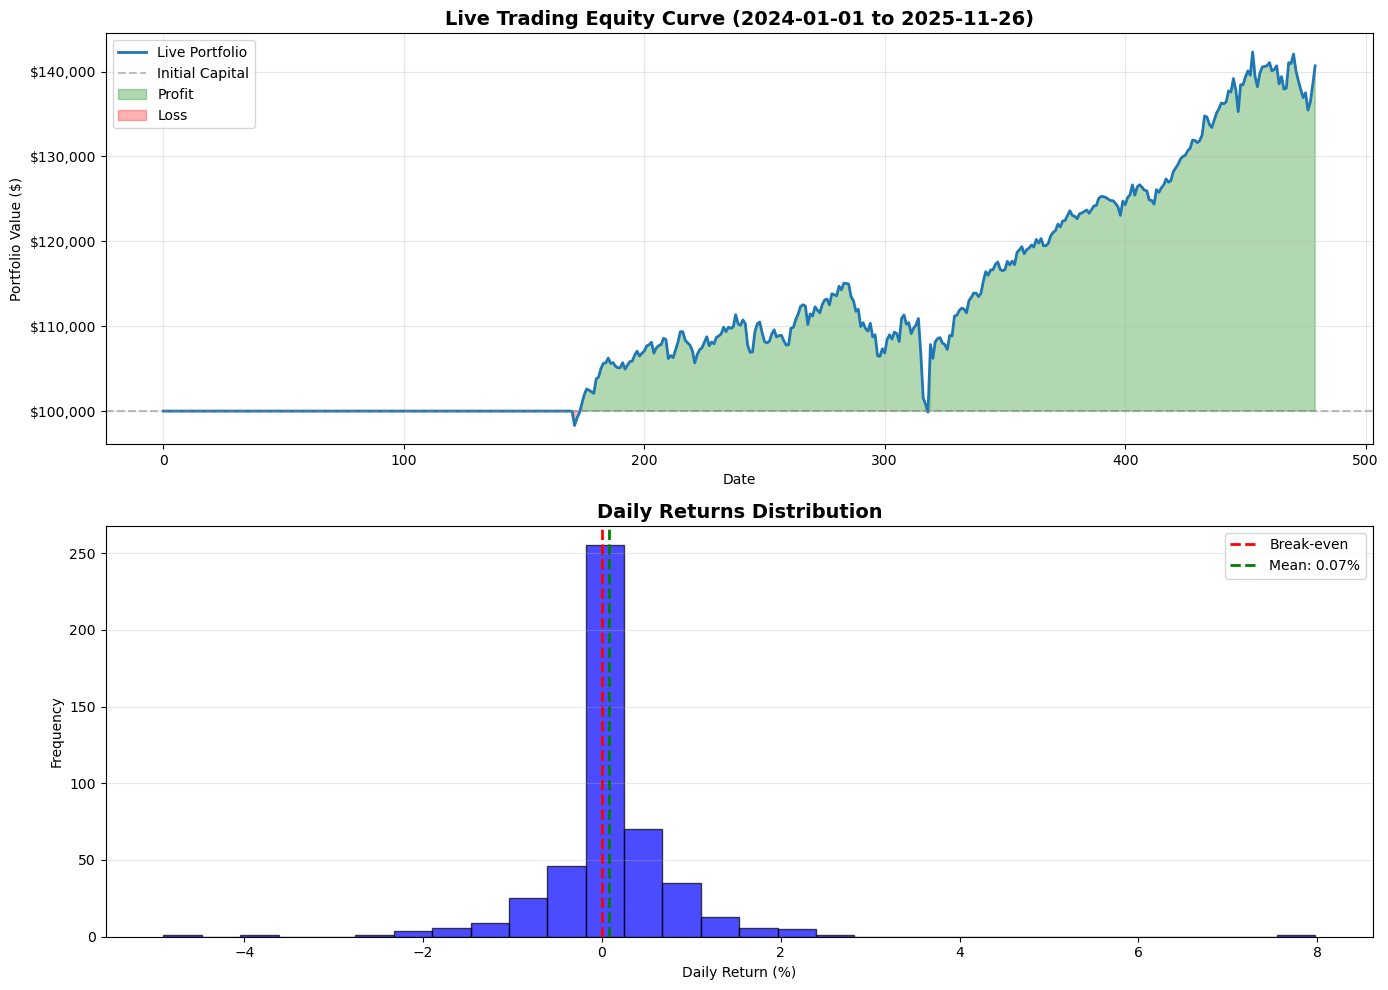


📊 Live Trading Statistics:
Total Days Traded:     480
Profitable Days:       181 (37.8%)
Losing Days:           129 (26.9%)
Best Day:              +7.98%
Worst Day:             -4.91%
Avg Daily Return:      +0.07%
Daily Return Std Dev:  0.77%

💰 Final Results:
Starting Capital:  $100,000.00
Ending Capital:    $140,680.50
Total P&L:         $40,680.50 (+40.68%)

✅ PROFITABLE: Live trading beat expectations!


In [12]:
# Visualize live trading results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Equity Curve
ax1 = axes[0]
# Note: equity curve has 'TotalValue' column, not 'Portfolio_Value'
live_equity['TotalValue'].plot(ax=ax1, linewidth=2, label='Live Portfolio')
ax1.axhline(y=portfolio_config.initial_capital, color='gray', linestyle='--', 
            alpha=0.5, label='Initial Capital')
ax1.fill_between(live_equity.index, 
                  portfolio_config.initial_capital, 
                  live_equity['TotalValue'],
                  where=live_equity['TotalValue'] >= portfolio_config.initial_capital,
                  alpha=0.3, color='green', label='Profit')
ax1.fill_between(live_equity.index, 
                  portfolio_config.initial_capital, 
                  live_equity['TotalValue'],
                  where=live_equity['TotalValue'] < portfolio_config.initial_capital,
                  alpha=0.3, color='red', label='Loss')
ax1.set_title(f'Live Trading Equity Curve ({live_start} to {live_end})', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 2: Daily Returns Distribution
ax2 = axes[1]
daily_returns = live_equity['TotalValue'].pct_change().dropna()
ax2.hist(daily_returns * 100, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax2.axvline(x=daily_returns.mean() * 100, color='green', linestyle='--', 
            linewidth=2, label=f'Mean: {daily_returns.mean()*100:.2f}%')
ax2.set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Daily Return (%)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Live Trading Statistics:")
print("="*70)
print(f"Total Days Traded:     {len(live_equity)}")
print(f"Profitable Days:       {(daily_returns > 0).sum()} ({(daily_returns > 0).sum()/len(daily_returns)*100:.1f}%)")
print(f"Losing Days:           {(daily_returns < 0).sum()} ({(daily_returns < 0).sum()/len(daily_returns)*100:.1f}%)")
print(f"Best Day:              {daily_returns.max()*100:+.2f}%")
print(f"Worst Day:             {daily_returns.min()*100:+.2f}%")
print(f"Avg Daily Return:      {daily_returns.mean()*100:+.2f}%")
print(f"Daily Return Std Dev:  {daily_returns.std()*100:.2f}%")

# Final capital
final_capital = live_equity['TotalValue'].iloc[-1]
total_pnl = final_capital - portfolio_config.initial_capital

print(f"\n💰 Final Results:")
print("="*70)
print(f"Starting Capital:  ${portfolio_config.initial_capital:,.2f}")
print(f"Ending Capital:    ${final_capital:,.2f}")
print(f"Total P&L:         ${total_pnl:,.2f} ({total_pnl/portfolio_config.initial_capital*100:+.2f}%)")

if total_pnl > 0:
    print(f"\n✅ PROFITABLE: Live trading beat expectations!")
else:
    print(f"\n⚠️  LOSS: Strategy underperformed in this period")

In [13]:
# Generate interactive HTML report using Reporter class
from core.reporter import Reporter
import webbrowser

# Initialize reporter
reports_dir = Path.cwd().parent.parent / 'reports'
reporter = Reporter(output_dir=str(reports_dir))

if isinstance(live_trades, pd.DataFrame) and len(live_trades) > 0:
    # Prepare equity curve DataFrame
    equity_for_report = live_equity.copy()
    
    # Ensure proper Date column and index
    if 'Date' not in equity_for_report.columns:
        equity_for_report = equity_for_report.reset_index()
        # Handle various index name possibilities
        if 'index' in equity_for_report.columns:
            equity_for_report.rename(columns={'index': 'Date'}, inplace=True)
        elif equity_for_report.columns[0] != 'Date':
            equity_for_report.rename(columns={equity_for_report.columns[0]: 'Date'}, inplace=True)
    
    # Ensure Date column is datetime type
    equity_for_report['Date'] = pd.to_datetime(equity_for_report['Date'])
    
    # Generate report title
    report_title = f"Live Trading Report - Momentum Strategy (Lookback={best_params['lookback']:.0f}, SMA={best_params['sma_filter']:.0f})"
    
    # Add walk-forward context to metrics
    enhanced_metrics = live_metrics.copy()
    enhanced_metrics['Expected OOS Sharpe'] = wf_results['oos_sharpe_mean']
    enhanced_metrics['Expected OOS Return'] = wf_results['oos_return_mean']
    enhanced_metrics['Strategy'] = f"Momentum (Lookback={best_params['lookback']:.0f}, SMA={best_params['sma_filter']:.0f})"
    
    # Generate HTML report
    report_filename = f'live_trades_report_{live_start}_{live_end}.html'
    report_path = reports_dir / report_filename
    
    print(f"\n📊 Generating comprehensive HTML report...")
    print(f"   Using Reporter class with interactive Plotly charts")
    
    html_output = reporter.generate_html_report(
        equity_df=equity_for_report,
        trades_df=live_trades,
        metrics=enhanced_metrics,
        title=report_title,
        save_path=str(report_path)
    )
    
    print(f"\n✅ Trade Report Generated!")
    print(f"📁 Location: {report_path}")
    print(f"📊 Total Trades: {len(live_trades)}")
    print(f"📈 Charts: Equity curve, drawdown, returns distribution, monthly heatmap")
    print(f"\n🌐 Opening in browser...")
    
    # Open in browser
    webbrowser.open(f'file://{report_path.absolute()}')
    
    print(f"\n💡 Features included:")
    print(f"   - Interactive Plotly charts (hover for details)")
    print(f"   - Equity curve with drawdown analysis")
    print(f"   - Returns distribution and trade analysis")
    print(f"   - Monthly returns heatmap")
    print(f"   - Performance metrics vs expectations")
    print(f"\n💡 You can also manually open: {report_path}")
    
else:
    print("\n⚠️  No trades to report")


📊 Generating comprehensive HTML report...
   Using Reporter class with interactive Plotly charts


/Users/Sakarias/QuantTrading/core/reporter.py:381: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



✅ Report saved to: /Users/Sakarias/QuantTrading/reports/live_trades_report_2024-01-01_2025-11-26.html

✅ Trade Report Generated!
📁 Location: /Users/Sakarias/QuantTrading/reports/live_trades_report_2024-01-01_2025-11-26.html
📊 Total Trades: 6
📈 Charts: Equity curve, drawdown, returns distribution, monthly heatmap

🌐 Opening in browser...

💡 Features included:
   - Interactive Plotly charts (hover for details)
   - Equity curve with drawdown analysis
   - Returns distribution and trade analysis
   - Monthly returns heatmap
   - Performance metrics vs expectations

💡 You can also manually open: /Users/Sakarias/QuantTrading/reports/live_trades_report_2024-01-01_2025-11-26.html

💡 Features included:
   - Interactive Plotly charts (hover for details)
   - Equity curve with drawdown analysis
   - Returns distribution and trade analysis
   - Monthly returns heatmap
   - Performance metrics vs expectations

💡 You can also manually open: /Users/Sakarias/QuantTrading/reports/live_trades_report_20